# Script for the Project

## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import folium
from shapely.geometry import Point
import webbrowser as wb
import json
import geojson
import plotly.express as px
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from dash import Dash, dcc, html, Input, Output
from math import radians, sin, cos, sqrt, atan2

The following command is just so that all columns appear on the representations

In [2]:
pd.set_option('display.max_columns',None)

## Functions

We will define some functions that we will use later.
1. haversine_distance: computes the distance between set of coordinates and a reference point given. 

In [3]:
def haversine_distance(row, ref_lat, ref_lon):
    lat1, lon1 = radians(row['latitude']), radians(row['longitude'])
    lat2, lon2 = radians(ref_lat), radians(ref_lon)
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    R = 6371  # Radius of Earth in kilometers
    distance = R * c
    
    return distance

## Preprocessing

In [4]:
df = pd.read_csv("Sevilla/listings/listings.csv")

In [5]:
df.describe()

,id,scrape_id,description,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,7.158000e+03,7.158000e+03,0.0,7.158000e+03,7158.000000,7158.000000,7158.000000,7158.000000,7158.000000,0.0,0.0,7097.000000,7158.000000,7158.000000,7158.000000,7158.000000,7158.000000,7158.000000,7158.000000,7158.000000,0.0,7158.000000,7158.000000,7158.000000,7158.000000,7158.000000,7158.000000,7158.000000,6428.000000,6428.000000,6428.000000,6427.000000,6428.000000,6428.000000,6427.000000,7158.000000,7158.000000,7158.000000,7158.000000,6428.000000
mean,3.279806e+17,2.023123e+13,NaN,1.818566e+08,27.485191,37.346605,37.390276,-5.990934,3.923582,NaN,NaN,2.499789,3.012434,563.055183,2.810562,5.504471,691.278430,764.698379,3.696032,727.680008,NaN,13.912965,31.336267,48.969964,168.451383,70.623358,18.745739,0.969684,4.686669,4.745829,4.718279,4.792953,4.794546,4.810341,4.620420,16.149763,14.936714,1.123219,0.038419,1.867677
std,4.107961e+17,0.000000e+00,NaN,1.678800e+08,83.542703,128.875003,0.009153,0.011707,1.925364,NaN,NaN,1.625450,10.295738,455.845916,10.109013,15.036119,469.811851,438.323191,11.350426,442.855735,NaN,9.523500,19.452660,28.761173,119.277330,106.961204,21.968493,1.495110,0.370797,0.342749,0.342524,0.303927,0.327436,0.283592,0.386933,28.597068,28.775563,4.051701,0.416314,1.676328
min,3.234700e+04,2.023123e+13,NaN,1.399390e+05,1.000000,1.000000,37.316680,-6.014953,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.622095e+07,2.023123e+13,NaN,3.082312e+07,2.000000,2.000000,37.386142,-5.997350,2.000000,NaN,NaN,1.000000,1.000000,90.000000,1.000000,2.000000,365.000000,365.000000,1.600000,365.000000,NaN,5.000000,16.000000,28.000000,61.250000,5.000000,2.000000,0.000000,4.600000,4.680000,4.630000,4.750000,4.750000,4.750000,4.520000,1.000000,1.000000,0.000000,0.000000,0.560000
50%,4.948352e+07,2.023123e+13,NaN,1.314159e+08,6.000000,7.000000,37.390140,-5.992272,4.000000,NaN,NaN,2.000000,2.000000,365.000000,2.000000,3.000000,999.000000,1125.000000,2.000000,999.000000,NaN,15.000000,34.000000,54.000000,163.000000,28.000000,10.000000,0.000000,4.770000,4.830000,4.800000,4.870000,4.890000,4.900000,4.700000,5.000000,4.000000,0.000000,0.000000,1.390000
75%,7.718286e+17,2.023123e+13,NaN,3.041168e+08,25.000000,29.000000,37.395637,-5.987010,5.000000,NaN,NaN,3.000000,2.000000,1125.000000,2.000000,4.000000,1125.000000,1125.000000,2.700000,1125.000000,NaN,22.000000,49.000000,74.000000,280.000000,89.000000,29.000000,1.000000,4.900000,4.930000,4.930000,4.950000,4.970000,4.980000,4.830000,18.750000,16.000000,0.000000,0.000000,2.750000
max,1.056439e+18,2.023123e+13,NaN,5.527191e+08,1197.000000,2510.000000,37.433200,-5.901415,16.000000,NaN,NaN,33.000000,365.000000,1130.000000,365.000000,365.000000,1130.000000,1130.000000,365.000000,1130.000000,NaN,30.000000,60.000000,90.000000,365.000000,1104.000000,153.000000,12.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,161.000000,161.000000,34.000000,7.000000,12.650000


All this columns will not influence the price of the Airbnb, after a session of brainstorming we consider relevant the following ones:

In [6]:
rel_col = ['id','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost',\
           'host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications',\
           'host_has_profile_pic','host_identity_verified','neighbourhood','bathrooms','bathrooms_text',\
           'latitude','longitude','room_type','number_of_reviews','accommodates',\
           'beds','price','has_availability','review_scores_rating',\
           'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
           'review_scores_communication','review_scores_location','review_scores_value','license',\
           'reviews_per_month']

In [7]:
df = df[rel_col]
df.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,bathrooms,bathrooms_text,latitude,longitude,room_type,number_of_reviews,accommodates,beds,price,has_availability,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,reviews_per_month
0,561654306981369438,within an hour,100%,100%,f,Casco Antiguo,49,53,"['email', 'phone']",t,t,NaN,NaN,1 bath,37.389172,-6.009562,Entire home/apt,16,4,2.0,$281.00,t,4.69,4.75,4.75,4.94,4.81,4.81,4.56,VFT/SE/04999,0.78
1,15479525,within an hour,100%,99%,f,Casco Antiguo,5,10,"['email', 'phone']",t,t,NaN,NaN,3 baths,37.389670,-5.995620,Entire home/apt,119,10,7.0,$484.00,t,4.63,4.55,4.59,4.74,4.68,4.96,4.55,VFT/SE/00873,1.36
2,12785235,NaN,NaN,0%,f,Sur,5,7,"['email', 'phone']",t,t,"Sevilla, Andalucia, Spain",NaN,1 bath,37.370020,-5.977260,Private room,0,2,1.0,$66.00,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,914985505906780237,within an hour,100%,100%,t,NaN,5,5,"['email', 'phone', 'work_email']",t,t,NaN,NaN,1 bath,37.396814,-5.999763,Entire home/apt,10,3,2.0,$93.00,t,4.90,5.00,4.80,4.90,5.00,4.70,4.90,A/SE/00432,1.79
4,686891099292953953,NaN,NaN,100%,f,NaN,1,2,"['email', 'phone']",t,t,NaN,NaN,2 baths,37.386195,-6.004393,Entire home/apt,1,7,4.0,$700.00,t,5.00,5.00,5.00,5.00,5.00,5.00,5.00,VFT/SE/02161,0.11


Let's see the datatypes of the dataframe

In [8]:
df.dtypes

id                               int64
host_response_time              object
host_response_rate              object
host_acceptance_rate            object
host_is_superhost               object
host_neighbourhood              object
host_listings_count              int64
host_total_listings_count        int64
host_verifications              object
host_has_profile_pic            object
host_identity_verified          object
neighbourhood                   object
bathrooms                      float64
bathrooms_text                  object
latitude                       float64
longitude                      float64
room_type                       object
number_of_reviews                int64
accommodates                     int64
beds                           float64
price                           object
has_availability                object
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin    

And the null values

In [9]:
df.isnull().sum()

id                                0
host_response_time              366
host_response_rate              366
host_acceptance_rate            203
host_is_superhost                 8
host_neighbourhood             3273
host_listings_count               0
host_total_listings_count         0
host_verifications                0
host_has_profile_pic              0
host_identity_verified            0
neighbourhood                  2773
bathrooms                      7158
bathrooms_text                   12
latitude                          0
longitude                         0
room_type                         0
number_of_reviews                 0
accommodates                      0
beds                             61
price                            46
has_availability                 46
review_scores_rating            730
review_scores_accuracy          730
review_scores_cleanliness       730
review_scores_checkin           731
review_scores_communication     730
review_scores_location      

We can see there is a lot of missing data.

In [10]:
df.count()

id                             7158
host_response_time             6792
host_response_rate             6792
host_acceptance_rate           6955
host_is_superhost              7150
host_neighbourhood             3885
host_listings_count            7158
host_total_listings_count      7158
host_verifications             7158
host_has_profile_pic           7158
host_identity_verified         7158
neighbourhood                  4385
bathrooms                         0
bathrooms_text                 7146
latitude                       7158
longitude                      7158
room_type                      7158
number_of_reviews              7158
accommodates                   7158
beds                           7097
price                          7112
has_availability               7112
review_scores_rating           6428
review_scores_accuracy         6428
review_scores_cleanliness      6428
review_scores_checkin          6427
review_scores_communication    6428
review_scores_location      

Let us do a preprocess on the data.

In [11]:
# Filter by number_of_reviews > 5 and have a reponse_time != NaN
df = df[df['number_of_reviews']>5 | (~df['host_response_time'].isna())]
df = (
    df
    # Drop the bathrooms column
    .drop(['bathrooms'], axis=1)
    # Create again the bathroom column with the information from bathrooms_text
    .assign(bathrooms=lambda x: x['bathrooms_text'].str.extract('(\d+)', expand=False).fillna(0).astype(int))
    # Drop the column bathroom_text
    .drop(['bathrooms_text'], axis=1)
    # Turn price into a float with the price
    .assign(price=lambda x: x['price'].replace({'\$': '', ',': ''}, regex=True).fillna(0).astype(float))
    # Turn the NaN values in the bed's column into 0 beds
    .assign(beds=lambda x: x['beds'].fillna(0)) 
    # Create a column for the distance of a room to Plaza España in Sevilla (37.377261, -5.986598)
    .assign(dist=lambda x: x.apply(haversine_distance, ref_lat=37.377261, ref_lon=-5.986598, axis=1))
    # Turn host_response_rate and host_acceptance_rate into integers
    .assign(host_response_rate=lambda x: x['host_response_rate'].str.extract('(\d+)', expand=False).fillna(0).astype(int))
    .assign(host_acceptance_rate=lambda x: x['host_acceptance_rate'].str.extract('(\d+)', expand=False).fillna(0).astype(int))
    # Turn the column host_verification into columns host_has_email, host_has_phone and host_has_work_email
    .assign(host_has_email=lambda x: x['host_verifications'].apply(lambda lst: 'email' in lst))
    .assign(host_has_phone=lambda x: x['host_verifications'].apply(lambda lst: 'phone' in lst))
    .assign(host_has_work_email=lambda x: x['host_verifications'].apply(lambda lst: 'work_email' in lst))
    # Drop column host_verifications
    .drop(['host_verifications'], axis=1)
    # Turn host_has_profile_pic, host_identity_verified, host_is_superhost and has_availability into booleans
    .assign(host_has_profile_pic=lambda x: x['host_has_profile_pic'].apply(lambda x: 't'==x))
    .assign(host_identity_verified=lambda x: x['host_identity_verified'].apply(lambda x: 't'==x))
    .assign(host_is_superhost=lambda x: x['host_is_superhost'].apply(lambda x: 't'==x))
    .assign(has_availability=lambda x: x['has_availability'].apply(lambda x: 't'==x))
    # Turn the column licence into a boolean column has_licence
    .assign(has_license=lambda x: ~x['license'].isna())
    # Drop the column license
    .drop(['license'],axis=1)
)

Let's see how many NaN values do we have in the column 'neighbourhood'.

In [12]:
df['neighbourhood'].isna().sum()

2083

Since the neighbourhooh column has a lot of missing data in listings.csv, we will merge the data from listings_summary.csv

In [13]:
df_s = pd.read_csv('Sevilla/listings/listings_summary.csv')
# Drop the column neighbourhood
df = df.drop(['neighbourhood'],axis=1)
# Merge from listings_summary.csv
df = pd.merge(df, df_s[['id', 'neighbourhood']], on='id', how='left')
df.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,number_of_reviews,accommodates,beds,price,has_availability,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,dist,host_has_email,host_has_phone,host_has_work_email,has_license,neighbourhood
0,561654306981369438,within an hour,100,100,False,Casco Antiguo,49,53,True,True,37.389172,-6.009562,Entire home/apt,16,4,2.0,281.0,True,4.69,4.75,4.75,4.94,4.81,4.81,4.56,0.78,1,2.422970,True,True,False,True,Triana Oeste
1,15479525,within an hour,100,99,False,Casco Antiguo,5,10,True,True,37.389670,-5.995620,Entire home/apt,119,10,7.0,484.0,True,4.63,4.55,4.59,4.74,4.68,4.96,4.55,1.36,3,1.593524,True,True,False,True,Alfalfa
2,914985505906780237,within an hour,100,100,True,NaN,5,5,True,True,37.396814,-5.999763,Entire home/apt,10,3,2.0,93.0,True,4.90,5.00,4.80,4.90,5.00,4.70,4.90,1.79,1,2.465821,True,True,True,True,San Vicente
3,23120468,NaN,0,0,False,Casco Antiguo,1,2,True,True,37.390950,-5.987670,Entire home/apt,28,4,3.0,150.0,True,4.71,4.82,4.68,4.82,4.68,4.89,4.46,0.40,1,1.525091,True,True,True,True,San Bartolomé
4,721526982103530146,within an hour,99,100,False,Casco Antiguo,151,269,True,True,37.390148,-5.991705,Entire home/apt,28,6,4.0,0.0,False,4.93,4.93,4.86,4.96,4.86,4.96,4.89,2.37,2,1.502335,True,True,True,True,Alfalfa


See how many NaN values appear on the neighbourhood column now.

In [14]:
df['neighbourhood'].isna().sum()

0

So this problem is now solved.

In [15]:
df.describe()

,id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,number_of_reviews,accommodates,beds,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,dist
count,6.081000e+03,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000,6081.000000
mean,2.707728e+17,93.765335,94.192567,22.718138,31.201940,37.390514,-5.991081,83.074330,3.963164,2.530669,173.958724,4.693950,4.752457,4.720786,4.795726,4.801158,4.813414,4.629245,1.955512,1.272817,1.900064
std,3.826105e+17,21.092256,17.977615,49.578083,82.532791,0.008772,0.011384,111.520092,1.897096,1.609722,528.008374,0.308365,0.289456,0.299568,0.252976,0.265543,0.239981,0.325000,1.679339,0.612426,0.825445
min,3.234700e+04,0.000000,0.000000,1.000000,1.000000,37.319640,-6.014780,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.500000,1.000000,0.020000,0.000000,0.191274
25%,2.355432e+07,100.000000,99.000000,2.000000,2.000000,37.386224,-5.997350,12.000000,2.000000,1.000000,86.000000,4.600000,4.680000,4.630000,4.740000,4.750000,4.750000,4.520000,0.640000,1.000000,1.362382
50%,4.400128e+07,100.000000,100.000000,6.000000,7.000000,37.390240,-5.992290,40.000000,4.000000,2.000000,126.000000,4.760000,4.830000,4.800000,4.860000,4.880000,4.890000,4.700000,1.500000,1.000000,1.766748
75%,6.852165e+17,100.000000,100.000000,24.000000,29.000000,37.395744,-5.987123,107.000000,5.000000,3.000000,186.000000,4.890000,4.920000,4.920000,4.940000,4.960000,4.970000,4.820000,2.860000,1.000000,2.282484
max,1.046503e+18,100.000000,100.000000,1197.000000,2510.000000,37.433200,-5.905070,1104.000000,16.000000,19.000000,34391.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,12.650000,7.000000,9.091517


## Label Encoding
In the case of the 'host_response_time' column, we see that there are 3 possible options: 'within an hour', 'within a day', 'within a few hours' and 'a few days or more'. We could apply here One-Hot Encoding, but notice it exists certain relation among the data, since 'within an hour'<'within a few hours'<'within a day'<'a few days or more'. For this reason, we will use the Label Encoding method:

In [16]:
response_time_order = {
    'within an hour': 0,
    'within a few hours': 1,
    'within a day': 2,
    'a few days or more': 3
}

df['response_time_label'] = df['host_response_time'].map(response_time_order)

In addition, we will do the same thing for the column room_type

In [17]:
room_type_order = {
    'Entire home/apt': 0,
    'Private room': 1,
    'Shared room': 2,
    'Hotel room': 3
}
df['room_type_label'] = df['room_type'].map(room_type_order)

In [18]:
df.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,room_type,number_of_reviews,accommodates,beds,price,has_availability,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,dist,host_has_email,host_has_phone,host_has_work_email,has_license,neighbourhood,response_time_label,room_type_label
0,561654306981369438,within an hour,100,100,False,Casco Antiguo,49,53,True,True,37.389172,-6.009562,Entire home/apt,16,4,2.0,281.0,True,4.69,4.75,4.75,4.94,4.81,4.81,4.56,0.78,1,2.422970,True,True,False,True,Triana Oeste,0.0,0
1,15479525,within an hour,100,99,False,Casco Antiguo,5,10,True,True,37.389670,-5.995620,Entire home/apt,119,10,7.0,484.0,True,4.63,4.55,4.59,4.74,4.68,4.96,4.55,1.36,3,1.593524,True,True,False,True,Alfalfa,0.0,0
2,914985505906780237,within an hour,100,100,True,NaN,5,5,True,True,37.396814,-5.999763,Entire home/apt,10,3,2.0,93.0,True,4.90,5.00,4.80,4.90,5.00,4.70,4.90,1.79,1,2.465821,True,True,True,True,San Vicente,0.0,0
3,23120468,NaN,0,0,False,Casco Antiguo,1,2,True,True,37.390950,-5.987670,Entire home/apt,28,4,3.0,150.0,True,4.71,4.82,4.68,4.82,4.68,4.89,4.46,0.40,1,1.525091,True,True,True,True,San Bartolomé,NaN,0
4,721526982103530146,within an hour,99,100,False,Casco Antiguo,151,269,True,True,37.390148,-5.991705,Entire home/apt,28,6,4.0,0.0,False,4.93,4.93,4.86,4.96,4.86,4.96,4.89,2.37,2,1.502335,True,True,True,True,Alfalfa,0.0,0


## Plotting
Once the preprocess is done, we can plot some data and see what can we do better. Let's start plotting the boxplots for the columns 'bathrooms', 'beds', 'accommodates' and 'price'.

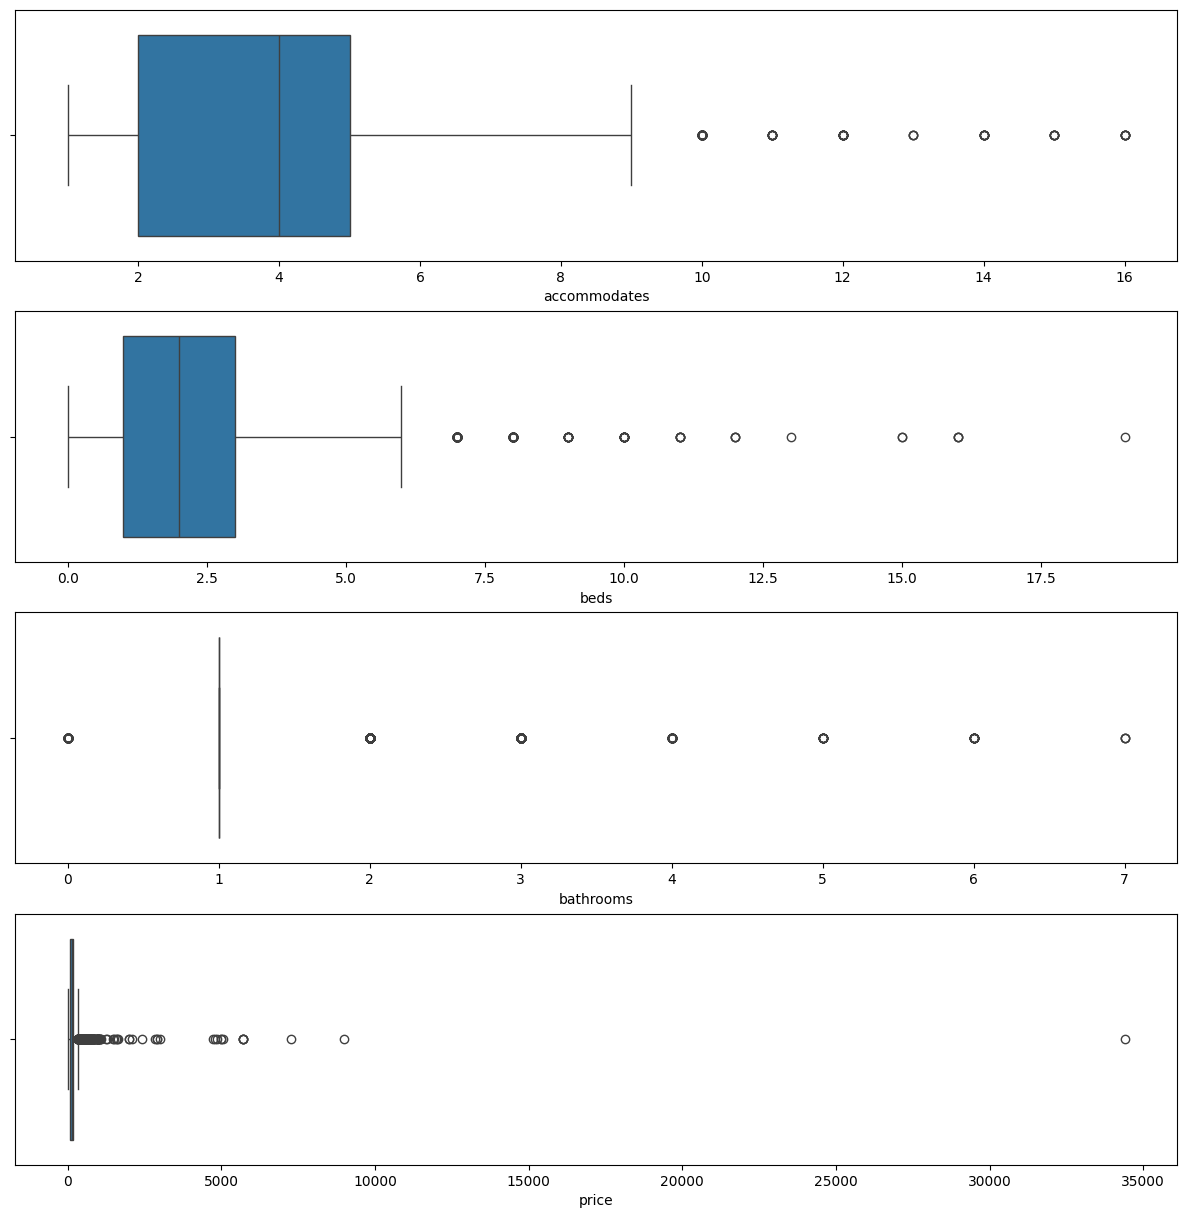

In [19]:
# Box plot for the accommodates, beds, bathrooms, price of the rooms
columns = ['accommodates', 'beds', 'bathrooms', 'price']
fig, axes = plt.subplots(nrows=len(columns))
fig.set_figheight(15)
fig.set_figwidth(15)

for c, axis in zip(columns, axes):
    sns.boxplot(data=df[c], ax=axis, orient='h') 

In the previous plot, we see that there are several outliers in both 'bathrooms' and 'price'. For now, we will not make any changes on 'bathrooms' but we will do some outlier detection on price.

<Axes: xlabel='price', ylabel='Count'>

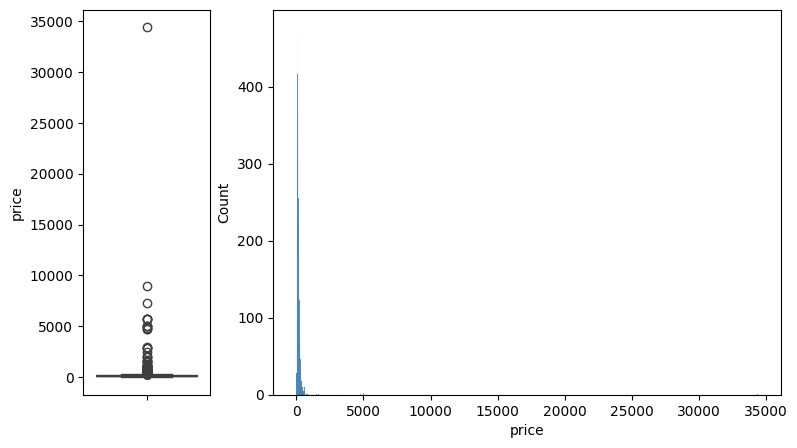

In [20]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
sns.boxplot(data=df['price'],ax=axes[0])
sns.histplot(data=df, x='price',ax=axes[1])

Let us apply the IQR technique.

In [21]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

small_outliers = df['price'] < (Q1 - 1.5 * IQR)
big_outliers = df['price'] > (Q3 + 1.5 * IQR)
sum(small_outliers), sum(big_outliers)

(0, 362)

If we now represent again the column:

<Axes: xlabel='price', ylabel='Count'>

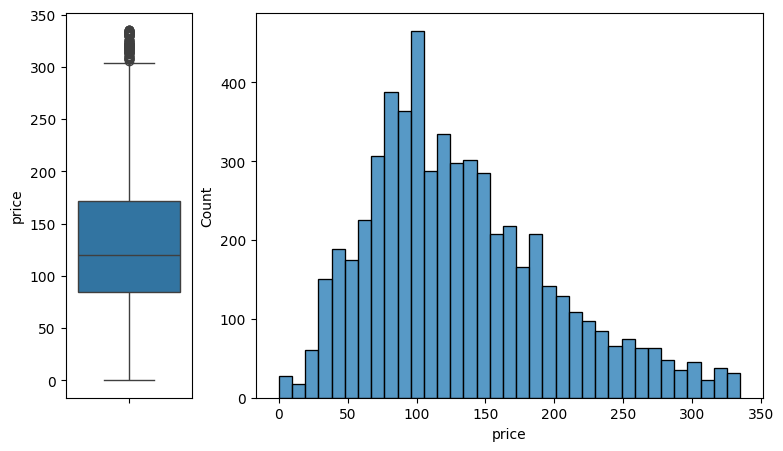

In [22]:
newdf = df[~(small_outliers | big_outliers)]
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
sns.boxplot(data=newdf['price'],ax=axes[0])
sns.histplot(data=newdf, x='price',ax=axes[1])

This looks way better than before so lets apply it to the dataframe

In [23]:
df = newdf

Let's also plot the distribution of this columns

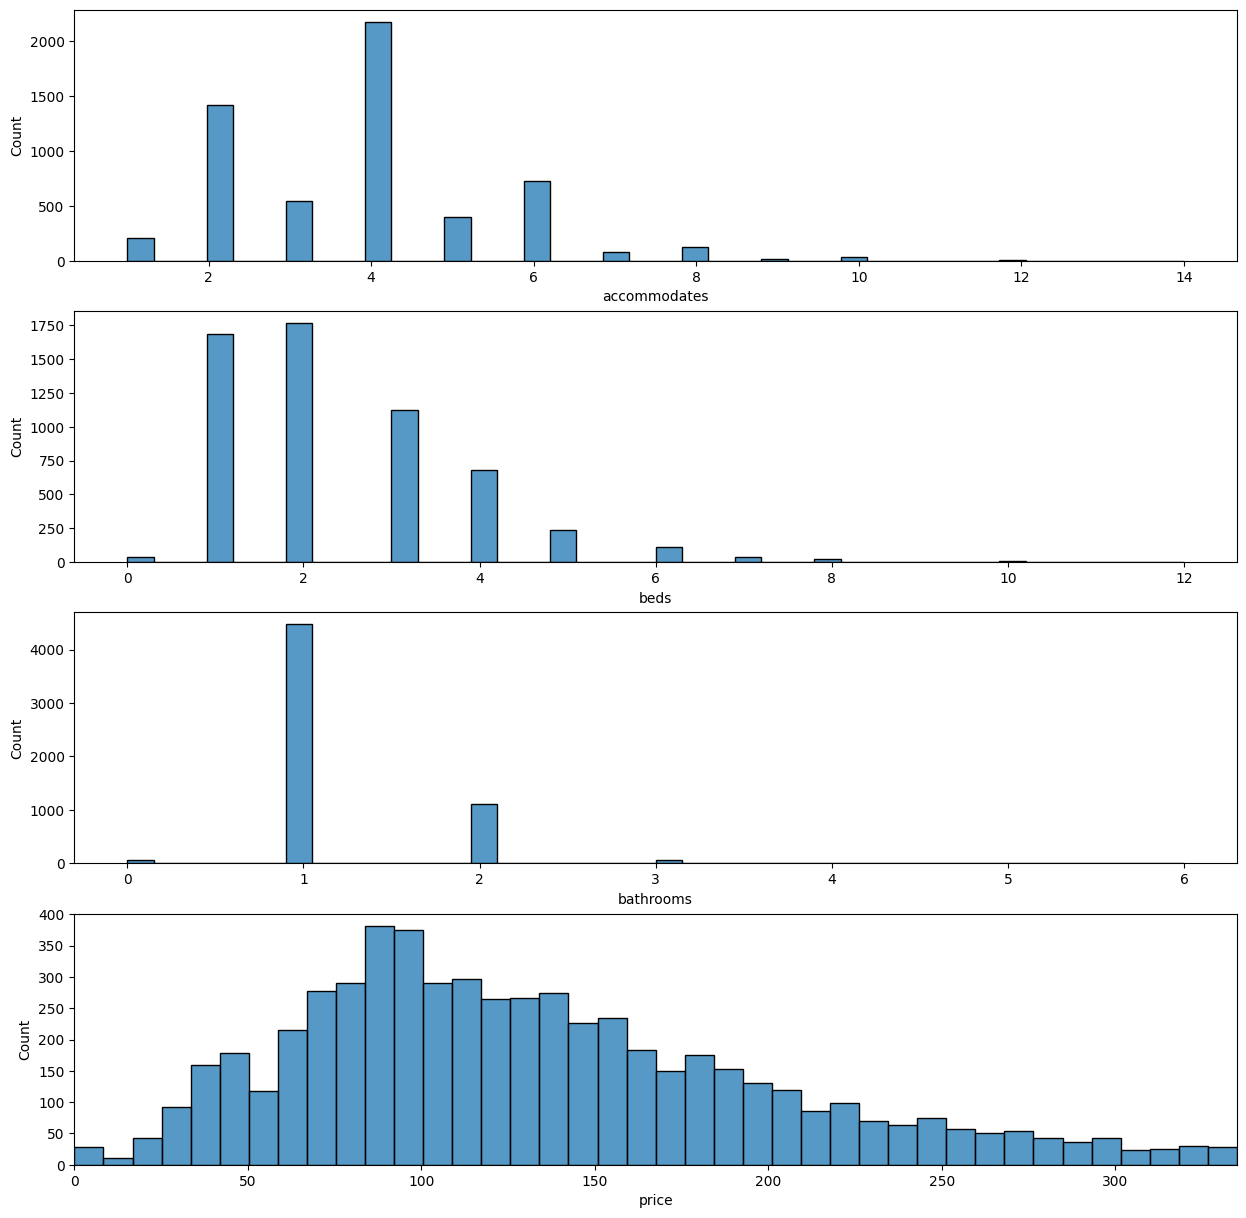

In [24]:
fig, axes = plt.subplots(nrows=len(columns))
fig.set_figheight(15)
fig.set_figwidth(15)

for c, axis in zip(columns, axes):
    sns.histplot(data=df, x=c, ax=axis, binwidth=(df[c].max()-df[c].min())/40.0)  
    plt.xlim(df[c].min(),df[c].max())


It is interesting to check the correlation between the numerical columns.

<Axes: >

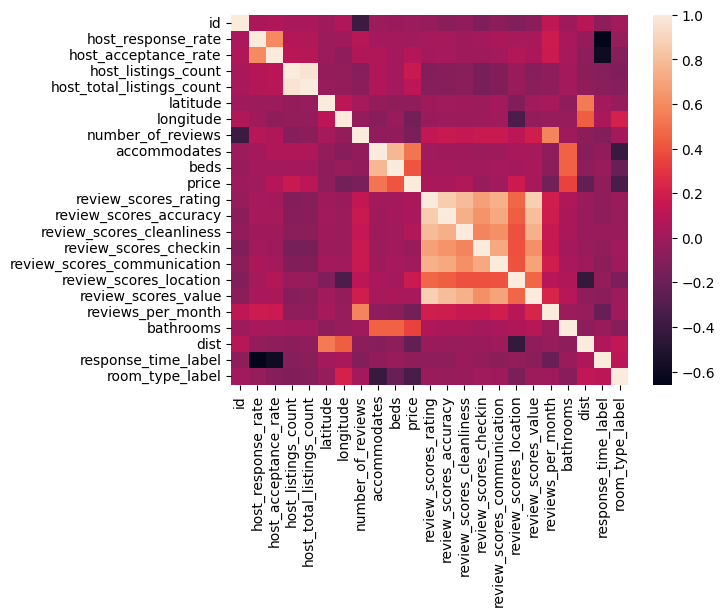

In [25]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=numerics)
sns.heatmap(newdf.corr())

In case we want to check the correlation more precisely:

In [26]:
def corrank(X: pd.DataFrame):
    import itertools
    df_corr = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])
    return df_corr.sort_values(by='corr',ascending=False)

In [27]:
a = corrank(newdf)

In [28]:
correl = a.set_index("pairs").to_dict()["corr"]

We will show only the data with correlation greater than 0.7 so that we can see the most relevant correlations.

In [29]:
{key: value for key, value in correl.items() if value > 0.7}

{('host_listings_count', 'host_total_listings_count'): 0.9673588666348606,
 ('review_scores_rating', 'review_scores_value'): 0.8724347721395426,
 ('review_scores_rating', 'review_scores_accuracy'): 0.8578375697360358,
 ('review_scores_accuracy', 'review_scores_value'): 0.8039920688396262,
 ('review_scores_rating', 'review_scores_cleanliness'): 0.7955959003498514,
 ('accommodates', 'beds'): 0.7776337462721616,
 ('review_scores_rating', 'review_scores_communication'): 0.7531984326835021,
 ('review_scores_cleanliness', 'review_scores_value'): 0.7528540134334406,
 ('review_scores_accuracy', 'review_scores_cleanliness'): 0.7468091934788013,
 ('review_scores_checkin', 'review_scores_communication'): 0.7176722535431359,
 ('review_scores_accuracy', 'review_scores_communication'): 0.7112609802062724}

## Geographycal information
Let us first of all read the files with data about the neighbourhoods and their geometry.

In [30]:
# Data about the neighbourhoods
neig_csv = pd.read_csv('Sevilla/neighbourhoods.csv')
# Geojson with the geometry of the neighbourhoods
with open('Sevilla/neighbourhoods.geojson') as f:
    gj = geojson.load(f)
# Geojson converted to dataframe
df_n = gpd.read_file('Sevilla/neighbourhoods.geojson')

With this data we can plot the amount of rooms per neighbourhood.

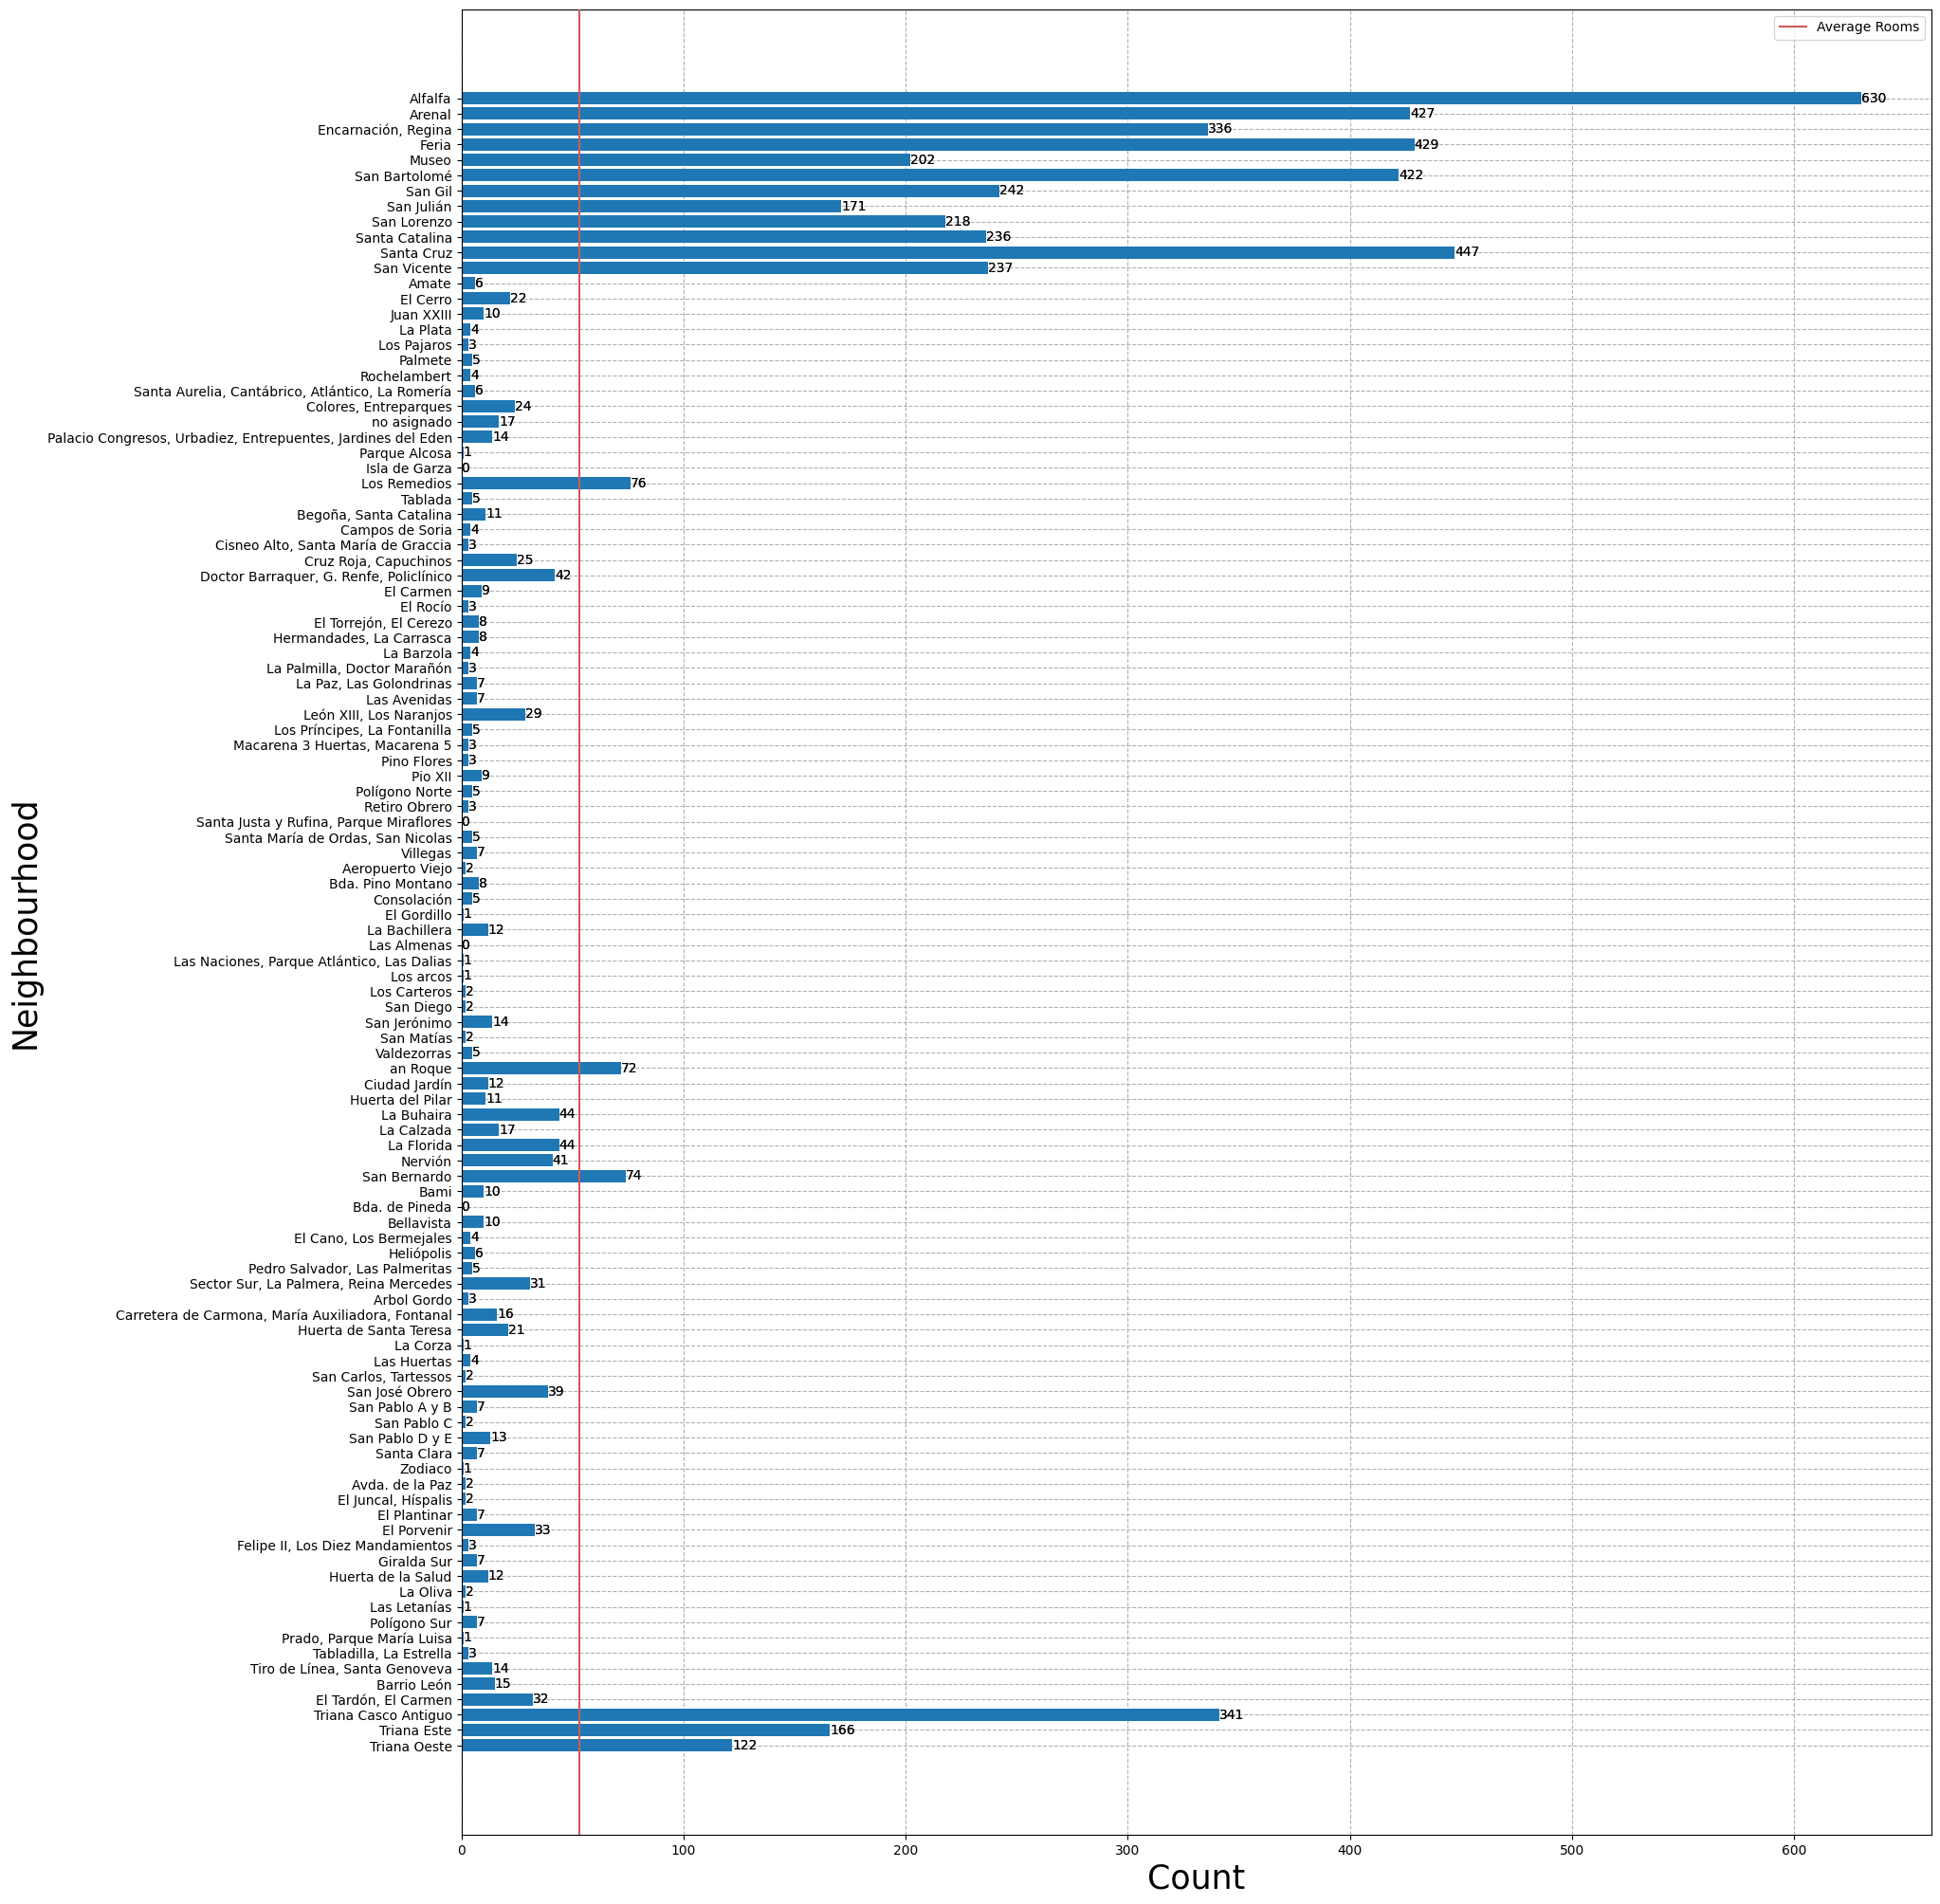

In [31]:
# Create a df with the neighbourhoods and the count of rooms on it 
dict = {'neighbourhood': [], 'count': []}
result = pd.DataFrame(dict)

for neighbourhood in neig_csv["neighbourhood"]:
    count = (df['neighbourhood'] == neighbourhood).sum()
    df2 = {'neighbourhood': neighbourhood, 'count': count}
    result = pd.concat([result, pd.DataFrame([df2])], ignore_index=True)

# Representation of the number of rooms per neighbourhood
y = result.loc[:,"neighbourhood"]
width = result.loc[:,"count"]

fig,ax = plt.subplots()
fig.set_size_inches(20, 25, forward=True)

bars = ax.barh(y,width,align='center',zorder=2) # Adds labels to the bars showing the name of the neighbourhoods    
labels_text = ax.bar_label(bars)
ax.invert_yaxis()
ax.grid(linestyle='--',zorder=0)

for container in ax.containers:
    ax.bar_label(container)
plt.yticks(y)
plt.axvline(np.average(width), color='#d15a5a',label="Average Rooms",zorder=3)  # Adds a vertical line representing the average rooms
plt.legend()
plt.ylabel("Neighbourhood",fontsize=25)
plt.xlabel("Count",fontsize=25)
plt.show()

Let's do the same thing but with the average price on every neighbourhood

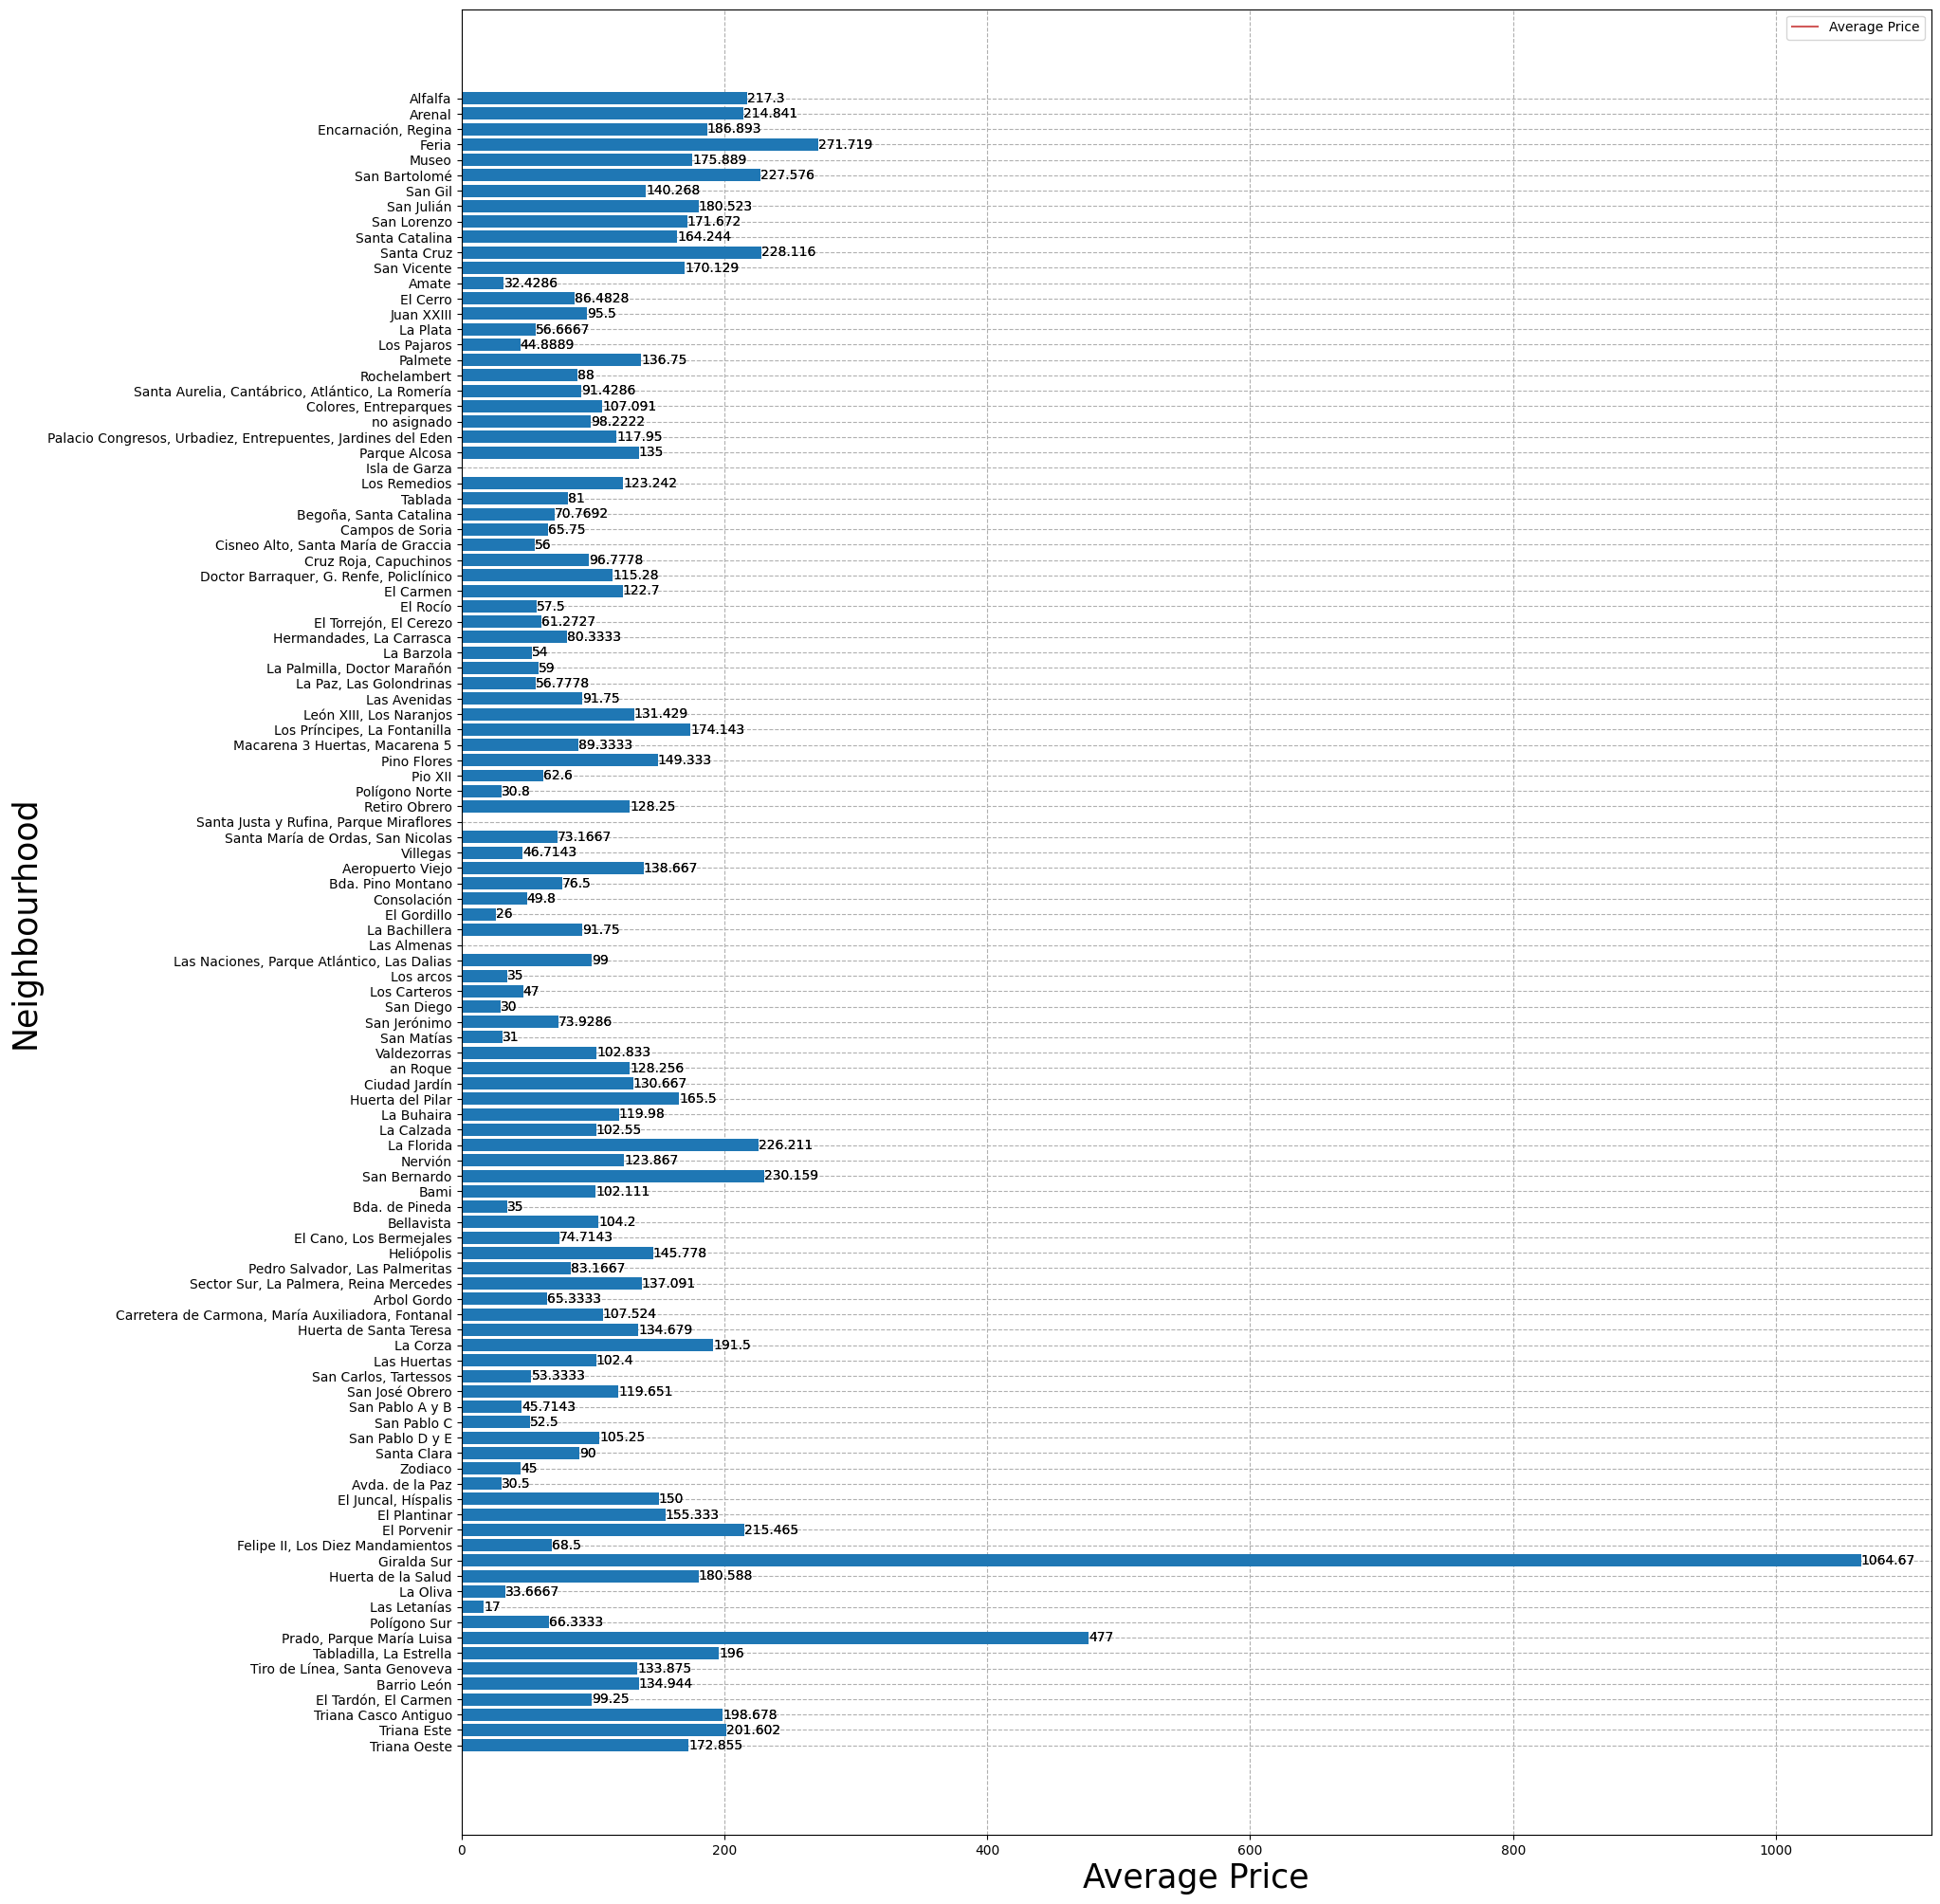

In [32]:
# Create a df with the neighbourhoods and the count of rooms on it 
dict = {'neighbourhood': [], 'avg_price': []}
result = pd.DataFrame(dict)

for neighbourhood in neig_csv["neighbourhood"]:
    avg_price = (df_s.loc[df_s['neighbourhood'] == neighbourhood, 'price']).mean()
    df2 = {'neighbourhood': neighbourhood, 'avg_price': avg_price}
    result = pd.concat([result, pd.DataFrame([df2])], ignore_index=True)

# Representation of the number of rooms per neighbourhood
y = result.loc[:,"neighbourhood"]
width = result.loc[:,"avg_price"]

fig,ax = plt.subplots()
fig.set_size_inches(20, 25, forward=True)

bars = ax.barh(y,width,align='center',zorder=2) # Adds labels to the bars showing the name of the neighbourhoods    
labels_text = ax.bar_label(bars)
ax.invert_yaxis()
ax.grid(linestyle='--',zorder=0)

for container in ax.containers:
    ax.bar_label(container)
plt.yticks(y)
plt.axvline(np.average(width), color='#d15a5a',label="Average Price",zorder=3)  # Adds a vertical line representing the average rooms
plt.legend()
plt.ylabel("Neighbourhood",fontsize=25)
plt.xlabel("Average Price",fontsize=25)
plt.show()

Something is going on here cause the code is not plotting the total average price.

Let's also create a choropleth that shows this same data in a map of Sevilla.

In [33]:
# Create a dataframe with the amount of Airbnbs per neighbourhood and the average price
dict = {'neighbourhood': [], 'count': [], 'avg_price': [], 'geometry': []}
result = pd.DataFrame(dict)

for index, row in df_n.iterrows():
    avg_price = (df.loc[df['neighbourhood'] == row["neighbourhood"], 'price']).mean()
    count = (df['neighbourhood'] == row["neighbourhood"]).sum()
    df2 = {'neighbourhood': row["neighbourhood"], 'count': count, 'avg_price': avg_price, 'geometry': row["geometry"]}
    result = pd.concat([result, pd.DataFrame([df2])], ignore_index=True)

# Represent the count of Airbnbs and the average price of them per neighbourhood

app = Dash(__name__)


app.layout = html.Div([
    html.H4('Choropleth map for Sevilla'),
    html.P("Select a feature:"),
    dcc.RadioItems(
        id='feature', 
        options=["count", "avg_price"],
        value="count",
        inline=True
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("feature", "value"))
def display_choropleth(feature):
    fig = px.choropleth(
        result,                     # DataFrame containing the data to be plotted
        geojson=gj,       # GeoJSON object containing geometry information for the map
        locations='neighbourhood',       # Column in 'df' that specifies the location to match with geojson
        featureidkey="properties.neighbourhood",
        color=feature,          # Column in 'df' used to determine the color of each geographic region
        color_continuous_scale="Viridis",  # Color scale for the choropleth map
        center = {"lat": 37.0902, "lon": -95.7129},            # Center of the image, eg. the coordinates of sevilla    
        labels={'count': 'count of Airbnb'}  # Custom labels for the legend and hover information
    )
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

    return fig

app.run_server(debug=True)